# I. Previous Research Results Particulairzation to Construction stocks

Date: 28/01/2020

In this notebook, the final model performance from the previous work by the author is evaluated in construction stocks.

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt
import seaborn as sn

import quandl

# Oversampling:
from imblearn.over_sampling import SMOTE
from collections import Counter

import statsmodels.api as sm
import xgboost as xgb

# Model evaluation:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / func

## 0. Loading the train and test data

We load the train and test datasets from the previous research work:

In [2]:
train = pd.read_csv('data_hec/train.csv',
                   parse_dates = ['ANNDT_ACT','FPEDATS','STATPERS'])
test = pd.read_csv('data_hec/test.csv',
                  parse_dates = ['ANNDT_ACT','FPEDATS','STATPERS'])

In [3]:
print('The dimensions of the train set are: %s' % str(train.shape))
print('The dimensions of the test set are: %s' % str(test.shape))

print('Interval of time covered by TRAIN: %s to %s' % (min(train.FPEDATS),max(train.FPEDATS)))
print('Interval of time covered by TEST: %s to %s' % (min(test.FPEDATS),max(test.FPEDATS)))

The dimensions of the train set are: (179572, 32)
The dimensions of the test set are: (43809, 32)
Interval of time covered by TRAIN: 2000-01-31 00:00:00 to 2014-12-31 00:00:00
Interval of time covered by TEST: 2015-01-31 00:00:00 to 2019-01-31 00:00:00


### 0.1. Subsetting construction stocks

Let's load the industry classification linking table and merge it to the test set:

In [4]:
# Loading the ICLINK linking table:
iclink = pd.read_csv('data/iclink.csv')

# Merge the company info to the test set:
test = test.merge(iclink[['TICKER','MG','IG']], on='TICKER', how='left')

And keep only the construction stocks in the test set:

In [5]:
# Companies of interest:
civil_eng = [15,16,17]

#iclink.loc[iclink.DIV == 'C'].groupby(['MG_DESC','IG_DESC']).TICKER.count().to_frame()

In [6]:
test_ceng = test.loc[test.MG.isin(civil_eng)]

There are only 32 construction stocks in the sample:

In [7]:
print('Number of Construction companies in the test set: %s' % test_ceng.TICKER.nunique())
print('Shape of the dataset: %s' % str(test_ceng.shape))

Number of Construction companies in the test set: 32
Shape of the dataset: (452, 34)


### 0.2. Load the CRSP monthly stock data

Here I am going to load the CRSP monthly stock data:

In [8]:
msf = pd.read_csv('data_hec/msf_prep.csv', parse_dates=['date'])
msf = msf.loc[msf.date >= '2015-01-31']

In [9]:
print('Shape of the dataset: %s' % str(msf.shape))
print('Interval of time covered: %s to %s' % (min(msf.date),max(msf.date)))
print('Number of Companies covered: %s' % msf.TICKER.nunique())

Shape of the dataset: (163567, 9)
Interval of time covered: 2015-01-31 00:00:00 to 2018-12-31 00:00:00
Number of Companies covered: 3856


## 1. Running the previous model

The model is trained in the full datasample, and tested only in construction stocks:

In [10]:
# Drop NaN:
tr = train.dropna()
te = test_ceng.dropna()

y_tr = tr['FEC']
X_tr = tr[['AFD1','AFD2','AFD3',
             'STDEV1','STDEV2','STDEV3',
             'NUMEST1','NUMEST2','NUMEST3',
             'StarRatio',
             'size',
             'car1','car2','car3',
             'indtr1','indtr2','indtr3',
             'FECq1','FECq2','FECq3','FECq4']]

y_te = te['FEC']
X_te = te[['AFD1','AFD2','AFD3',
             'STDEV1','STDEV2','STDEV3',
             'NUMEST1','NUMEST2','NUMEST3',
             'StarRatio',
             'size',
             'car1','car2','car3',
             'indtr1','indtr2','indtr3',
             'FECq1','FECq2','FECq3','FECq4']]

### 1.1. Oversampling with SMOTE

The dataset was heavyily inblanced 1:5:1, and we use oversampling to improve the model prediction.

In [11]:
# SMOTE creates synthetic samples of the minority class.
smote = SMOTE('auto')
X_sm, y_sm = smote.fit_resample(X_tr,y_tr)

# Dataframe format
X_sm = pd.DataFrame(X_sm, columns=X_tr.columns)

# Print shapes:
print(sorted(Counter(y_sm).items()))

/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(1, 62959), (2, 62959), (3, 62959)]


### 1.2.  Training and Model Results

In [12]:
# Define the model:
xgboost = xgb.XGBClassifier(booster = 'gbtree',
                            objective = 'mlogloss')

# Fit the model to the training data:
xgboost.fit(X_sm,y_sm)

# Make predictions for test data
y_pred = xgboost.predict(X_te)

## MODEL SUMMARY:

# Precision, recall and F1 score:
print(classification_report(y_te, y_pred,
                            labels=[1, 2, 3],
                            target_names=['Negative Surprise', 'No Surprise', 'Positive Surprise']))

                   precision    recall  f1-score   support

Negative Surprise       0.30      0.28      0.29        47
      No Surprise       0.82      0.90      0.86       286
Positive Surprise       0.24      0.10      0.14        42

         accuracy                           0.73       375
        macro avg       0.45      0.42      0.43       375
     weighted avg       0.69      0.73      0.71       375



And plot the confusion matrix:

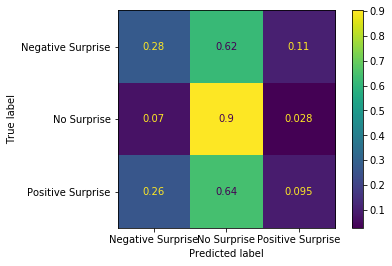

In [13]:
plot_confusion_matrix(xgboost,
                      X_te,y_te,
                      labels = np.array([1,2,3]),
                      display_labels = np.array(['Negative Surprise', 'No Surprise', 'Positive Surprise']),
                      normalize = 'true');

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision Surprises (macro avg.): %f' % precision_score(y_te, y_pred, average='macro', labels=[1,3]))
print('Recall Surprises (macro avg.): %f' % recall_score(y_te, y_pred, average='macro', labels=[1,3]))

Precision Surprises (macro avg.): 0.265374
Recall Surprises (macro avg.): 0.185917


## 2. Implementation of the Investment Strategy

Here, the predicted surprises are used as investment signals for our desired investment strategy.

In [15]:
# Create signals df:
signals = te[['TICKER','FPEDATS']]

# Add the predictions and rename:
signals['FEC_pred'] = y_pred
signals.columns = ['TICKER','FPEDATS','signal']

# Create year and month fields:
signals['PYEAR'] = signals.FPEDATS.dt.year
signals['PMON'] = signals.FPEDATS.dt.month

/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [16]:
# Select companies only reporting in FP as mentioned:
mon = [3,6,9,12]
signals = signals.loc[signals.PMON.isin(mon)]

In [17]:
print('Shape of the dataset: %s' % str(signals.shape))
print('Interval of time covered: %s to %s' % (min(signals.FPEDATS),max(signals.FPEDATS)))
print('Number of Companies covered: %s' % signals.TICKER.nunique())

Shape of the dataset: (303, 5)
Interval of time covered: 2015-03-31 00:00:00 to 2018-12-31 00:00:00
Number of Companies covered: 26


### 2.1. Create portfolios based on predicted surprises

For every quarter 3 portfolios are formed based on: positive surprise, no surprise or negative surprise.

In [18]:
dec = signals[['TICKER','PYEAR','PMON','signal']].groupby(['PYEAR','PMON','TICKER'], as_index=False).mean().sort_values(['PYEAR','PMON'])

# Format the date to be last day of month of Fiscal Period:
dec[['PYEAR','PMON']] = dec[['PYEAR','PMON']].astype('str')
dec['FPdate'] = np.where(dec.PMON == '12', dec.PYEAR + dec.PMON, dec.PYEAR +'0'+ dec.PMON)
dec['FPdate'] = pd.to_datetime(dec['FPdate'], format="%Y%m") + MonthEnd(1)

Set the holding periods:

In [19]:
#  Holding Period Length: K in months
K = 3

# Set holding period from start next month, K months:
dec['hdate1']=dec['FPdate']+MonthBegin(1)
dec['hdate2']=dec['hdate1']+MonthEnd(K) # End of holding period

And merge the surprise portfolio data with the monthly returns:

In [20]:
tmp_ret = msf[['TICKER','date','ret','sprtrn']]

# Merge both:
port = tmp_ret.merge(dec, on=['TICKER'], how='inner')

# Keep only rows of month data that are in holding period:
port = port[(port['hdate1']<=port['date']) & (port['date']<=port['hdate2'])]
port = port.sort_values(by=['date','signal','FPdate','TICKER']).drop_duplicates()

# Now average the monthly return over all securities in each portfolio:
dec2 = port.groupby(['date','signal','FPdate'])['ret','sprtrn'].mean().reset_index()

Compute each portfolio abnormal returns:

In [21]:
# Make regressions for each portfolio:

def estimate_alpha_beta(data):
    Y = data['ret']
    X = data['sprtrn']
    X = sm.add_constant(X)
    
    result = sm.OLS(Y, X).fit()
    
    return result.params

# Estimate alpha&beta:
alpha_beta = dec2.groupby('signal').apply(estimate_alpha_beta)
alpha_beta.columns = ['alpha','beta']

# Merge back:
dec2 = dec2.merge(alpha_beta, on='signal', how='left')

# Compute abnormal returns:
dec2['abret'] = dec2.ret - (dec2.alpha + dec2.beta*dec2.sprtrn)

# Drop ret and sprtrn:
dec2.drop(['sprtrn','alpha','beta'], axis=1, inplace=True)

Create one return series per surprise portfolio:

In [22]:
ewret = dec2.groupby(['date','signal'])['abret'].mean().reset_index()
ewstd = dec2.groupby(['date','signal'])['abret'].std().reset_index()
ewret = ewret.rename(columns={'abret':'ewret'})
ewstd = ewstd.rename(columns={'abret':'ewretstd'})
ewretdat = pd.merge(ewret, ewstd, on=['date','signal'], how='inner')
ewretdat = ewretdat.sort_values(by=['signal'])

In [23]:
# Pivot and format:
ewretdat2 = ewretdat.pivot_table(index=['date'], columns='signal', values='ewret')
ewretdat2 = ewretdat2.add_prefix('port')

### 2.2. Compute Long-Short portfolio returns

Now here we create a long-short portfolio:

In [24]:
# Fill NAs with zero:
ewretdat2.fillna(value=0,axis=1, inplace=True)

In [25]:
# Create the long_short portfolio:
ewretdat2['long_short'] = ewretdat2['port3'] - ewretdat2['port1']

In [26]:
# Compute the Cumulative returns:
ewretdat2['1+port1']=1+ewretdat2['port1']
ewretdat2['1+port3']=1+ewretdat2['port3']
ewretdat2['1+ls'] = 1+ewretdat2['long_short']

ewretdat2['car_port3']=ewretdat2['1+port3'].cumprod()-1
ewretdat2['car_port1']=ewretdat2['1+port1'].cumprod()-1
ewretdat2['car_long_short']=ewretdat2['1+ls'].cumprod()-1

### 2.3. Plot the different portfolios

First, plot the investment signals:

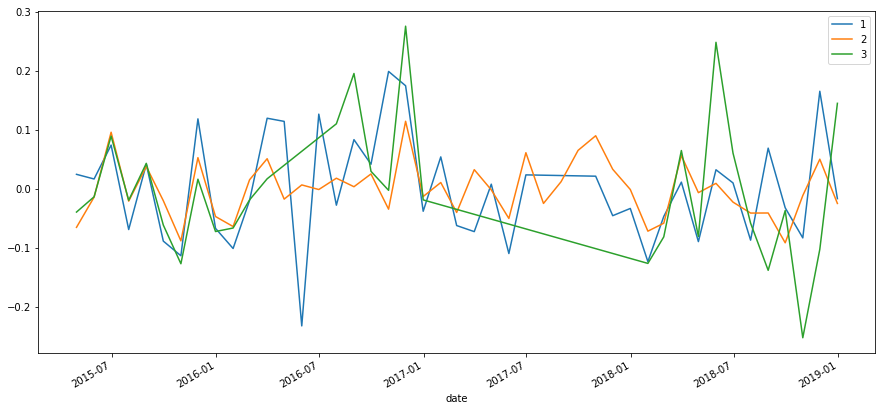

In [27]:
ewretdat.set_index('date').groupby('signal')['ewret'].plot(legend=True, figsize=(15,7));

And the cumulative abnormal returns:

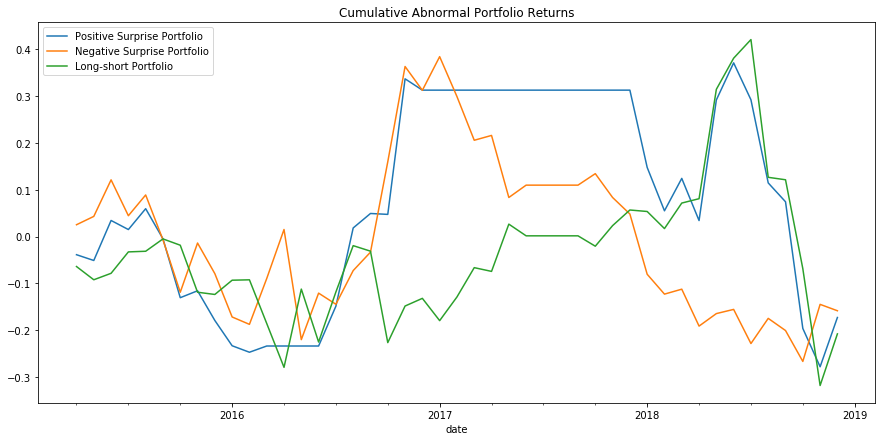

In [28]:
# Rename:
ewretdat3 = ewretdat2[['car_port3','car_port1','car_long_short']]
ewretdat3.columns = ['Positive Surprise Portfolio','Negative Surprise Portfolio','Long-short Portfolio']

fig = ewretdat3.plot(figsize=(15,7))
fig.set_title('Cumulative Abnormal Portfolio Returns')
plt.show()

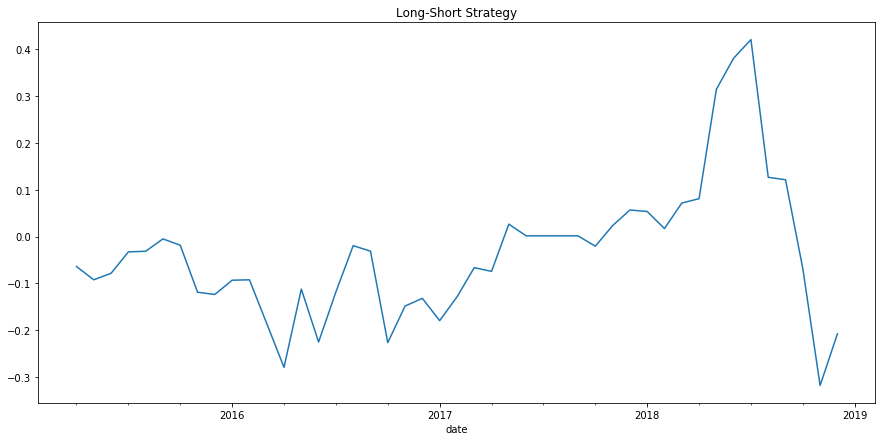

In [29]:
fig2 = ewretdat3['Long-short Portfolio'].plot(figsize=(15,7))
fig2.set_title('Long-Short Strategy')
plt.show()